In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import itertools
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import (
    make_scorer, f1_score, recall_score, accuracy_score, precision_score,
    roc_auc_score, confusion_matrix, classification_report)
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Input, UpSampling2D)
from tensorflow.keras.preprocessing.image import img_to_array
from hyperopt import fmin, tpe, hp
from tensorflow import keras
from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization


In [2]:
df = pd.read_csv('diabetes_ds.csv')

In [3]:
 #split
training, cv, test = \
              np.split(df.sample(frac=1, random_state=721), 
                       [int(.6*len(df)), int(.8*len(df))])

In [4]:
training['train_test'] = 1
cv['train_test'] = 0
test['train_test'] = 0


%matplotlib inline
training.columns

Index(['Age', 'Gender', 'BMI', 'SBP', 'DBP', 'FPG', 'Chol', 'Tri', 'HDL',
       'LDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'smoking', 'drinking',
       'family_histroy', 'Diabetes', 'train_test'],
      dtype='object')

In [5]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2581 entries, 1907 to 3771
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             2581 non-null   int64  
 1   Gender          2581 non-null   int64  
 2   BMI             2581 non-null   float64
 3   SBP             2581 non-null   int64  
 4   DBP             2581 non-null   int64  
 5   FPG             2581 non-null   float64
 6   Chol            2581 non-null   float64
 7   Tri             2581 non-null   float64
 8   HDL             2581 non-null   float64
 9   LDL             2581 non-null   float64
 10  ALT             2581 non-null   float64
 11  BUN             2581 non-null   float64
 12  CCR             2581 non-null   float64
 13  FFPG            2581 non-null   float64
 14  smoking         2581 non-null   float64
 15  drinking        2581 non-null   float64
 16  family_histroy  2581 non-null   int64  
 17  Diabetes        2581 non-null   int

In [6]:
training.describe()

,Age,Gender,BMI,SBP,DBP,FPG,Chol,Tri,HDL,LDL,ALT,BUN,CCR,FFPG,smoking,drinking,family_histroy,Diabetes,train_test
count,2581.000000,2581.000000,2581.000000,2581.000000,2581.000000,2581.000000,2581.00000,2581.000000,2581.000000,2581.000000,2581.000000,2581.000000,2581.000000,2581.000000,2581.000000,2581.000000,2581.000000,2581.000000,2581.0
mean,47.991476,1.348702,24.129729,123.074390,76.263076,5.207935,4.86406,1.581243,1.660005,2.974635,26.271873,4.853301,71.678345,5.724587,2.976414,3.189122,0.063929,0.294847,1.0
std,14.813620,0.476652,3.403819,17.206089,10.816445,0.778859,0.90728,1.179149,1.067998,0.878647,21.516409,1.269605,17.479314,1.498640,1.195749,0.928667,0.244673,0.456062,0.0
min,22.000000,1.000000,15.600000,77.000000,47.000000,2.840000,2.21000,0.000000,0.000000,1.000000,4.500000,1.950000,4.860753,3.200000,1.000000,1.000000,0.000000,0.000000,1.0
25%,35.000000,1.000000,21.700000,111.000000,69.000000,4.700000,4.21000,0.860000,1.140000,2.350000,14.200000,3.990000,60.200000,4.900000,3.000000,3.000000,0.000000,0.000000,1.0
50%,46.000000,1.000000,24.000000,122.000000,76.000000,5.120000,4.80000,1.280000,1.340000,2.820000,20.000000,4.760000,72.100000,5.300000,3.000000,3.000000,0.000000,0.000000,1.0
75%,60.000000,2.000000,26.300000,134.000000,83.000000,5.700000,5.44000,1.940000,1.610000,3.410000,30.700000,5.560000,82.400000,6.000000,3.000000,3.000000,0.000000,1.000000,1.0
max,91.000000,2.000000,38.700000,189.000000,120.000000,6.990000,9.28000,14.930000,4.860753,5.580000,279.200000,17.730000,307.000000,29.700000,4.860753,4.860753,1.000000,1.000000,1.0


In [7]:
df_num = training[['Age', 'BMI', 'SBP', 'DBP', 
                  'FPG', 'Chol', 'Tri', 'HDL',
                  'LDL', 'ALT', 'BUN', 'CCR', 
                  'FFPG']]
df_cat = training[['Gender', 'smoking', 'drinking',
       'family_histroy', 'Diabetes', 'train_test']]

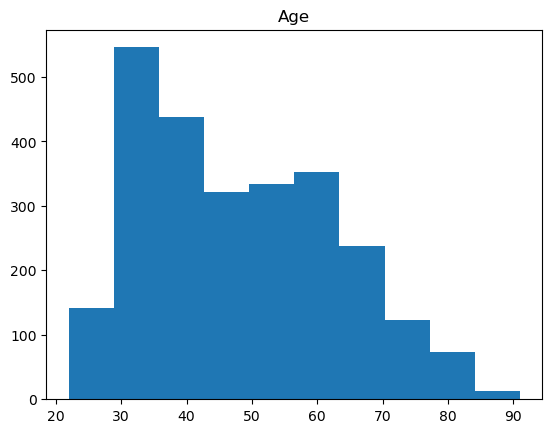

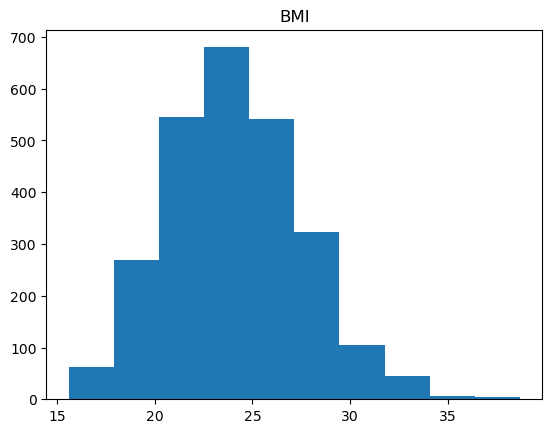

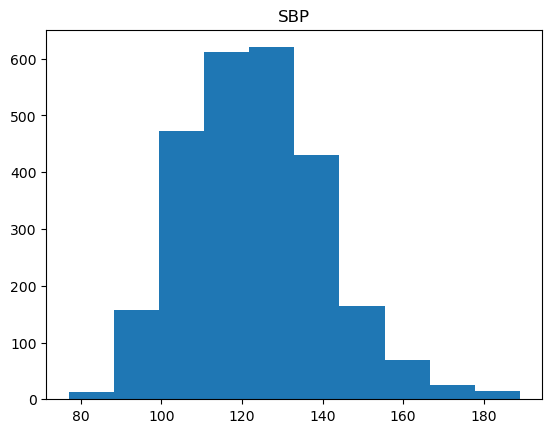

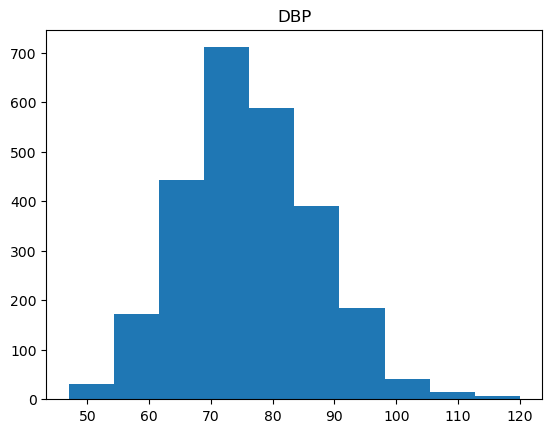

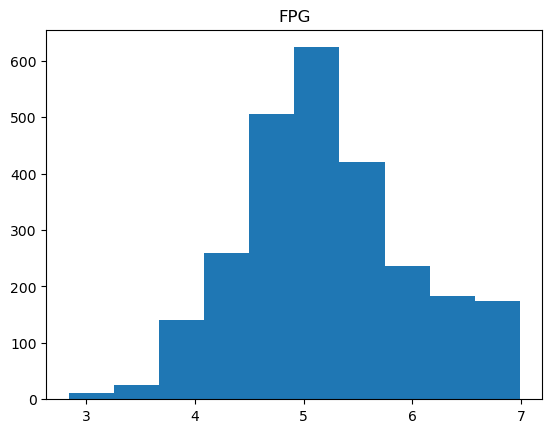

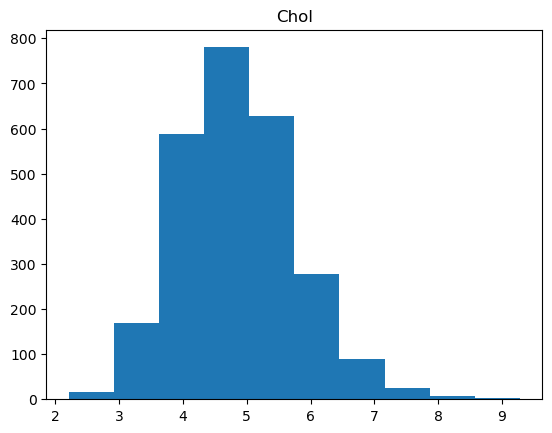

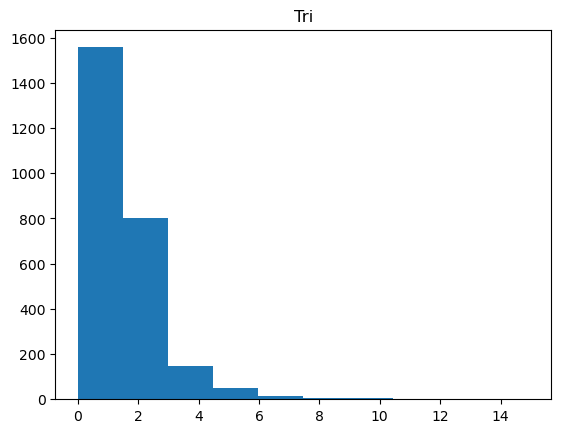

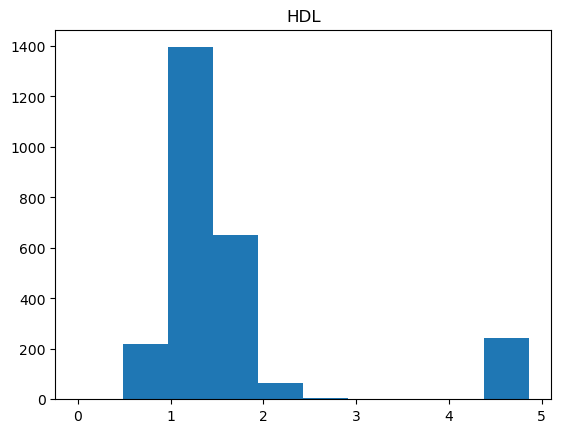

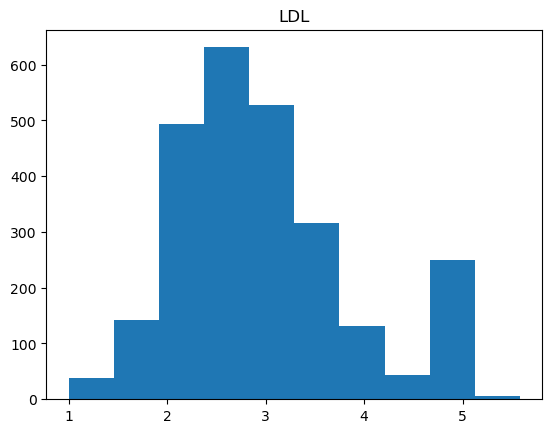

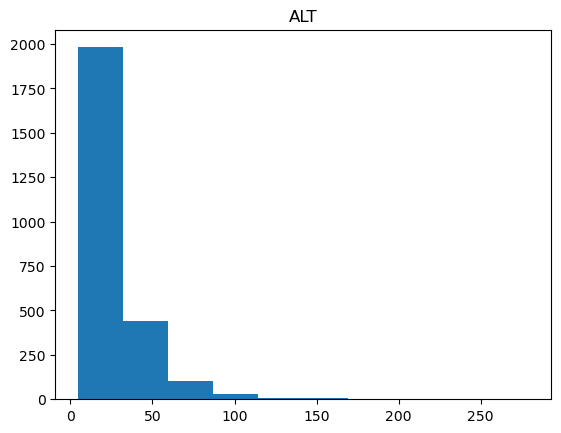

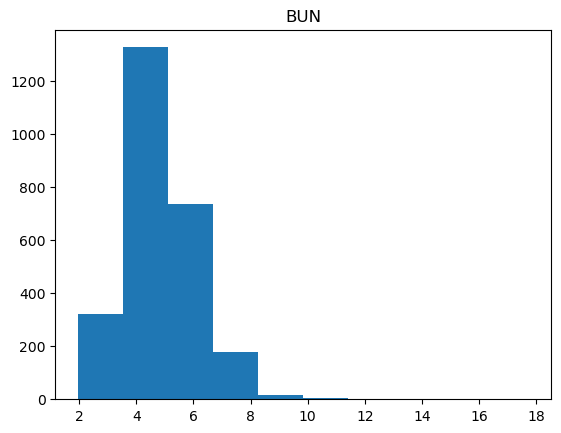

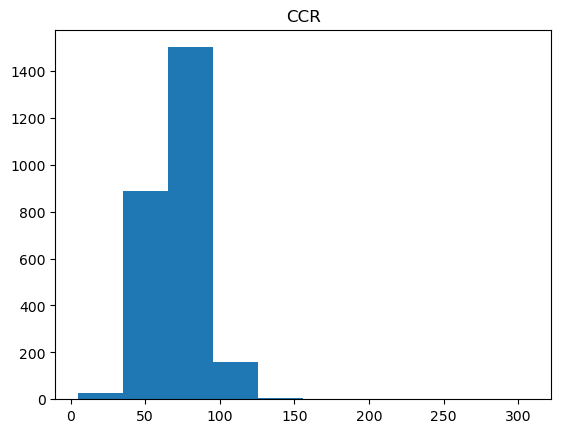

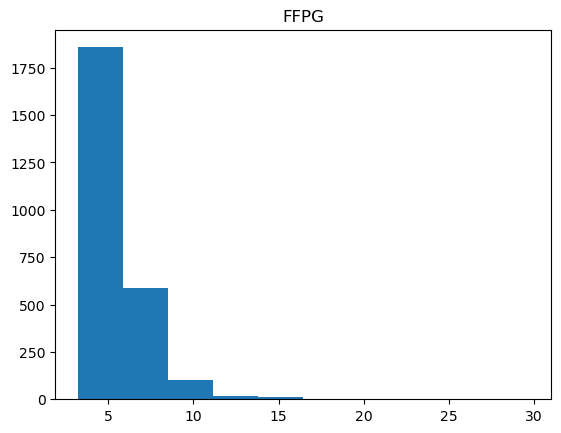

In [8]:
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

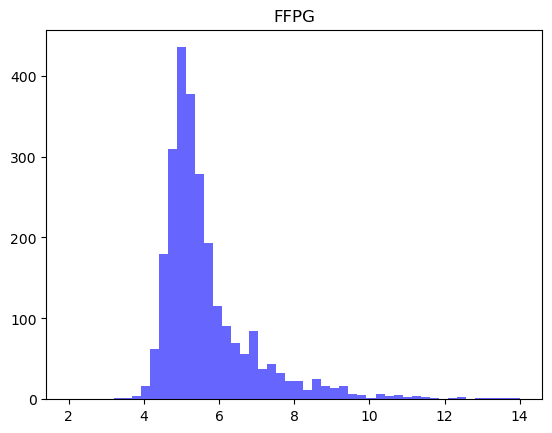

In [9]:

num_bins = 50

plt.hist(df_num['FFPG'], bins=num_bins, alpha=0.6, color='b', range=(2, 14))
plt.title('FFPG')

plt.savefig(f'FFPGFINAL.png')
plt.show()

<Axes: >

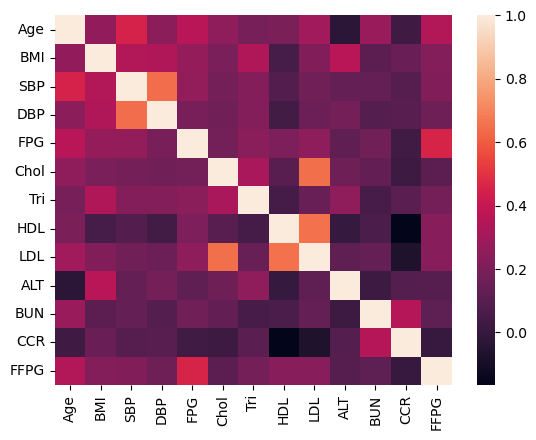

In [10]:
sns.heatmap(df_num.corr())

In [11]:
#aca muestra los valores medios de cada columna para los cuales el individuo es o no diabetico
pd.pivot_table(training, index = 'Diabetes', values = ['Age', 'BMI', 'SBP', 'DBP',
'FPG', 'Chol', 'Tri', 'HDL','LDL', 'ALT', 'BUN', 'CCR', 'FFPG'])

,ALT,Age,BMI,BUN,CCR,Chol,DBP,FFPG,FPG,HDL,LDL,SBP,Tri
Diabetes,,,,,,,,,,,,,
0,25.297802,43.107692,23.60828,4.728313,72.454720,4.793209,75.059890,5.177610,4.952181,1.342593,2.756626,119.898901,1.447401
1,28.601450,59.671485,25.37682,5.152222,69.821575,5.033506,79.140604,7.032733,5.819593,2.419123,3.496024,130.668857,1.901338


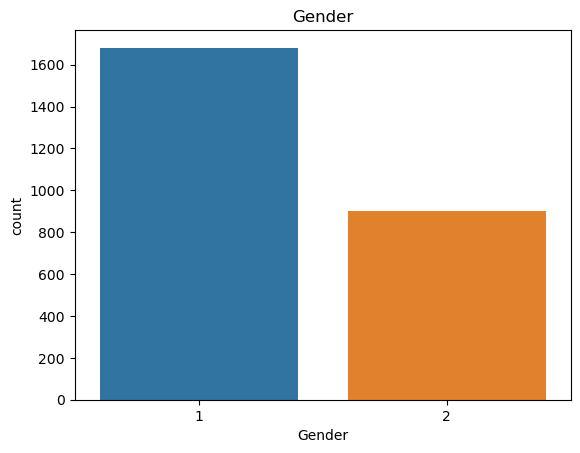

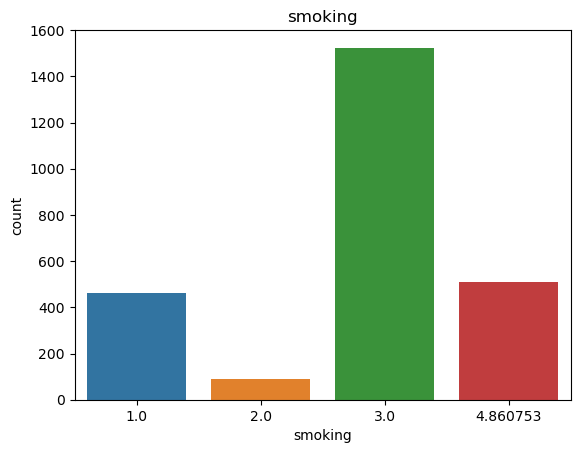

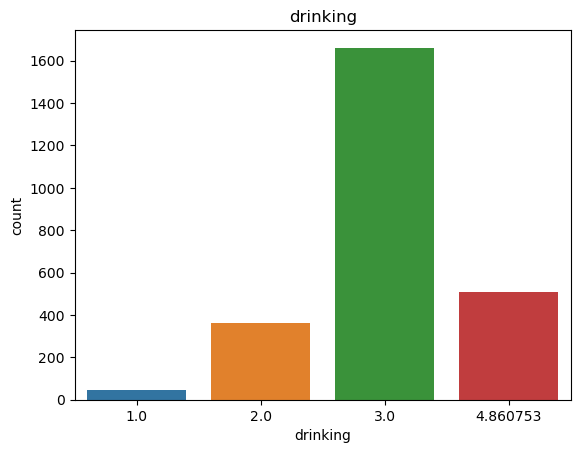

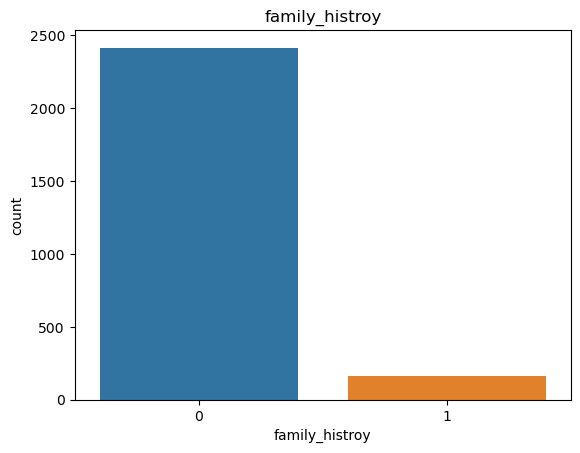

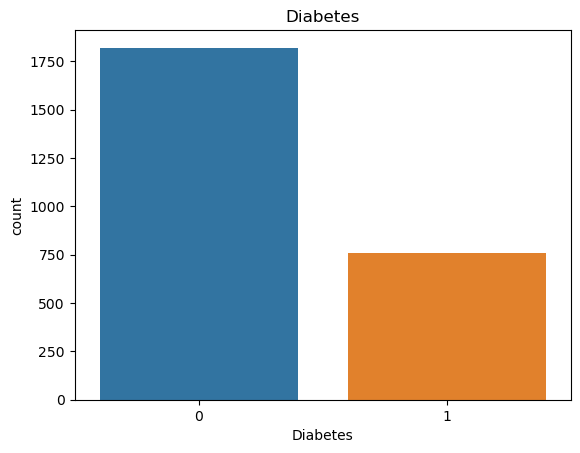

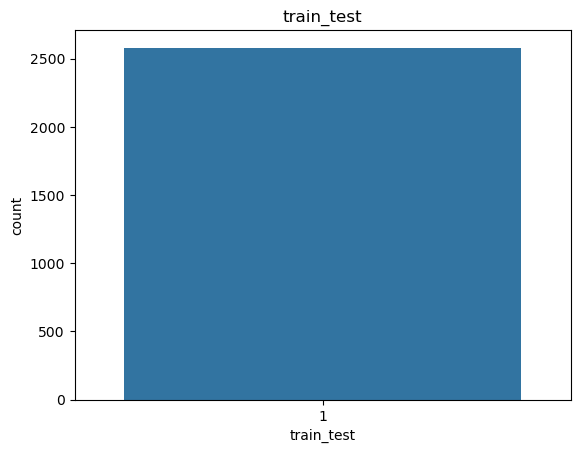

In [12]:
for i in df_cat.columns:
    sns.barplot(x=df_cat[i].value_counts().index,y=df_cat[i].value_counts()).set_title(i)
    plt.show()

In [13]:
print(pd.pivot_table(df_cat, index = 'Diabetes', columns = 'Gender', values = 'train_test' ,aggfunc ='count'))
print(pd.pivot_table(df_cat, index = 'Diabetes', columns = 'smoking', values = 'train_test' ,aggfunc ='count'))
print(pd.pivot_table(df_cat, index = 'Diabetes', columns = 'drinking', values = 'train_test' ,aggfunc ='count'))
print(pd.pivot_table(df_cat, index = 'Diabetes', columns = 'family_histroy', values = 'train_test' ,aggfunc ='count'))

Gender       1    2
Diabetes           
0         1189  631
1          492  269
smoking   1.000000  2.000000  3.000000  4.860753
Diabetes                                        
0            380.0      74.0    1366.0       NaN
1             80.0      14.0     158.0     509.0
drinking  1.000000  2.000000  3.000000  4.860753
Diabetes                                        
0             41.0     331.0    1448.0       NaN
1              7.0      32.0     213.0     509.0
family_histroy     0    1
Diabetes                 
0               1712  108
1                704   57


In [14]:
#created dummy variables from categories (also can use OneHotEncoder)
dummies_1= pd.get_dummies(training[['Age', 'Gender', 'BMI', 'SBP', 'DBP', 'FPG', 'Chol', 'Tri', 'HDL',
       'LDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'smoking', 'drinking',
       'family_histroy', 'Diabetes', 'train_test']])
dummies_2= pd.get_dummies(cv[['Age', 'Gender', 'BMI', 'SBP', 'DBP', 'FPG', 'Chol', 'Tri', 'HDL',
       'LDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'smoking', 'drinking',
       'family_histroy', 'Diabetes', 'train_test']])
dummies_3= pd.get_dummies(test[['Age', 'Gender', 'BMI', 'SBP', 'DBP', 'FPG', 'Chol', 'Tri', 'HDL',
       'LDL', 'ALT', 'BUN', 'CCR', 'FFPG', 'smoking', 'drinking',
       'family_histroy', 'Diabetes', 'train_test']])


#Split to train test again
X_train = dummies_1[dummies_1.train_test == 1].drop(['train_test'], axis =1)
X_cv = dummies_2[dummies_2.train_test == 0].drop(['train_test'], axis =1)
X_test = dummies_3[dummies_3.train_test == 0].drop(['train_test'], axis =1)

y_train = training[training.train_test==1].Diabetes


In [15]:
scale = StandardScaler()
dummies_1_scaled = dummies_1.copy()
dummies_1_scaled[['Age', 'BMI', 'SBP', 'DBP', 
                  'FPG', 'Chol', 'Tri', 'HDL',
                  'LDL', 'ALT', 'BUN', 'CCR', 
                  'FFPG']]= scale.fit_transform(dummies_1_scaled[['Age', 'BMI', 'SBP', 'DBP', 
                  'FPG', 'Chol', 'Tri', 'HDL',
                  'LDL', 'ALT', 'BUN', 'CCR', 
                  'FFPG']])
dummies_1_scaled

dummies_2_scaled = dummies_2.copy()
dummies_2_scaled[['Age', 'BMI', 'SBP', 'DBP', 
                  'FPG', 'Chol', 'Tri', 'HDL',
                  'LDL', 'ALT', 'BUN', 'CCR', 
                  'FFPG']]= scale.fit_transform(dummies_2_scaled[['Age', 'BMI', 'SBP', 'DBP', 
                  'FPG', 'Chol', 'Tri', 'HDL',
                  'LDL', 'ALT', 'BUN', 'CCR', 
                  'FFPG']])
dummies_2_scaled

dummies_3_scaled = dummies_3.copy()
dummies_3_scaled[['Age', 'BMI', 'SBP', 'DBP', 
                  'FPG', 'Chol', 'Tri', 'HDL',
                  'LDL', 'ALT', 'BUN', 'CCR', 
                  'FFPG']]= scale.fit_transform(dummies_3_scaled[['Age', 'BMI', 'SBP', 'DBP', 
                  'FPG', 'Chol', 'Tri', 'HDL',
                  'LDL', 'ALT', 'BUN', 'CCR', 
                  'FFPG']])
dummies_3_scaled

dummies_1_scaled = dummies_1_scaled[['drinking', 'smoking', 'FFPG', 'FPG', 'HDL', 'Age', 'LDL', 'train_test']]
dummies_2_scaled = dummies_2_scaled[['drinking', 'smoking', 'FFPG', 'FPG', 'HDL', 'Age', 'LDL', 'train_test']]
dummies_3_scaled = dummies_3_scaled[['drinking', 'smoking', 'FFPG', 'FPG', 'HDL', 'Age', 'LDL', 'train_test']]


X_train_scaled = dummies_1_scaled[dummies_1_scaled.train_test == 1].drop(['train_test'], axis =1)
X_cv_scaled = dummies_2_scaled[dummies_2_scaled.train_test == 0].drop(['train_test'], axis =1)
X_test_scaled = dummies_3_scaled[dummies_3_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = training[training.train_test==1].Diabetes
y_cv = cv[cv.train_test==0].Diabetes
y_test = test[test.train_test==0].Diabetes


In [16]:
classifiers = [
    ('GaussianNB', GaussianNB()),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('XGBoost', xgb.XGBClassifier(random_state=42))
]

best_accuracy_dict = {}
best_columns_dict = {}

# Get all possible combinations of 7 columns from X_train_scaled
column_combinations = list(itertools.combinations(X_train_scaled.columns, 7))

# For each classifier, test each combination of 7 columns
for clf_name, clf in classifiers:
    best_accuracy = 0
    best_columns = None

    for columns in column_combinations:
        # Get the indices of the selected columns
        column_indices = [X_train_scaled.columns.get_loc(col) for col in columns]
        
        # Get training data with the selected columns
        X_train_selected = X_train_scaled.iloc[:, column_indices]
        
        # Train the classifier
        clf.fit(X_train_selected, y_train)
        
        # Evaluate the classifier using cross-validation
        cv_accuracy = cross_val_score(clf, X_train_selected, y_train, cv=5, scoring='f1').mean()
        
        # Update the best results if we find a higher accuracy
        if cv_accuracy > best_accuracy:
            best_accuracy = cv_accuracy
            best_columns = columns
    
    # Save the best results for the current classifier
    best_accuracy_dict[clf_name] = best_accuracy
    best_columns_dict[clf_name] = best_columns

# Print the best results for each classifier
for clf_name, clf in classifiers:
    print(f"Best combination of columns for {clf_name}: {best_columns_dict[clf_name]}")
    print(f"Average accuracy for {clf_name}: {best_accuracy_dict[clf_name]}")
    print("------------------------")

Best combination of columns for GaussianNB: ('drinking', 'smoking', 'FFPG', 'FPG', 'HDL', 'Age', 'LDL')
Average accuracy for GaussianNB: 0.9234405855322482
------------------------
Best combination of columns for RandomForest: ('drinking', 'smoking', 'FFPG', 'FPG', 'HDL', 'Age', 'LDL')
Average accuracy for RandomForest: 0.9242029281110631
------------------------
Best combination of columns for XGBoost: ('drinking', 'smoking', 'FFPG', 'FPG', 'HDL', 'Age', 'LDL')
Average accuracy for XGBoost: 0.9263082766026779
------------------------


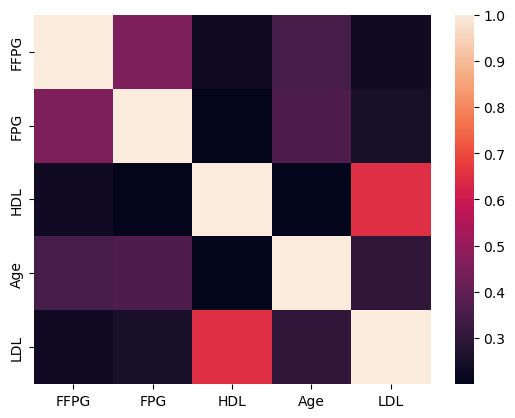

In [17]:
sns.heatmap(df_num[['FFPG', 'FPG', 'HDL', 'Age', 'LDL']].corr())
plt.savefig('heatmap.png') 

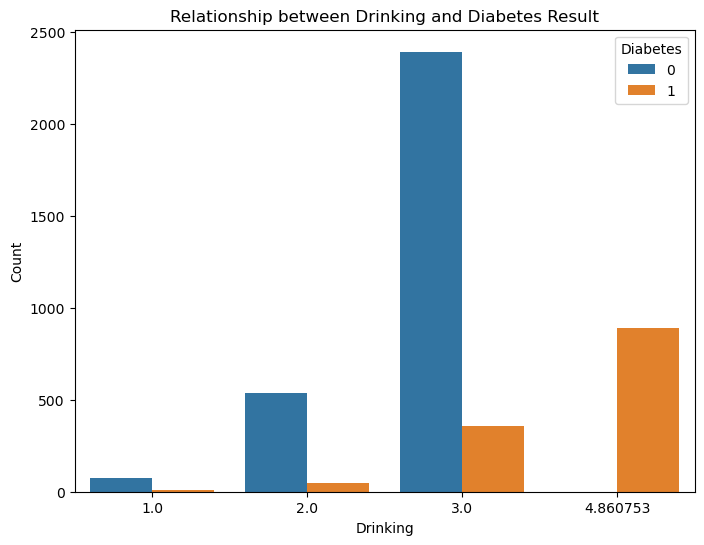

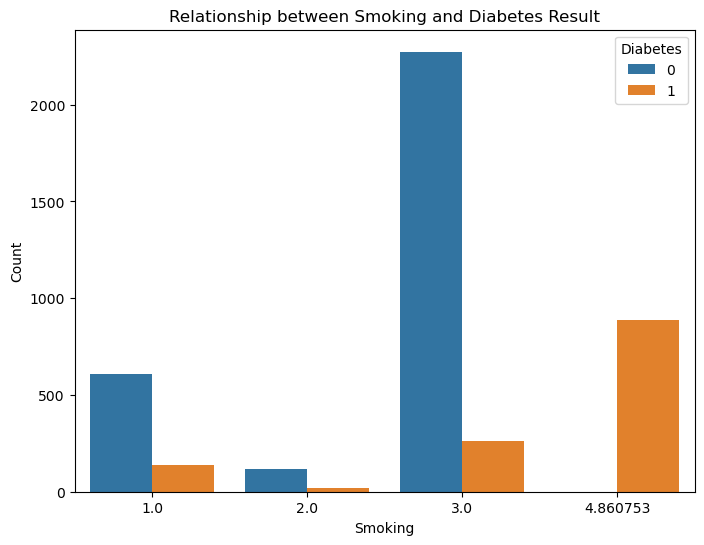

In [18]:
diabetes_variables = ['drinking', 'smoking', 'Diabetes']
diabetes_subset = df[diabetes_variables]


# Bar chart for 'drinking' in relation to diabetes
plt.figure(figsize=(8, 6))
sns.countplot(data=diabetes_subset, x='drinking', hue='Diabetes')
plt.title('Relationship between Drinking and Diabetes Result')
plt.xlabel('Drinking')
plt.ylabel('Count')
plt.savefig('fig3_drinking.png')
plt.show()

# Bar chart for 'smoking' in relation to diabetes
plt.figure(figsize=(8, 6))
sns.countplot(data=diabetes_subset, x='smoking', hue='Diabetes')
plt.title('Relationship between Smoking and Diabetes Result')
plt.xlabel('Smoking')
plt.ylabel('Count')
plt.savefig('fig3_smoking.png')
plt.show()


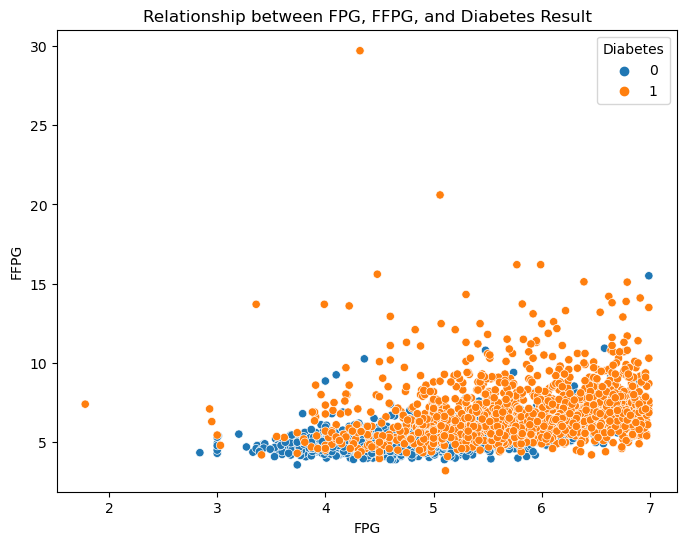

In [19]:
# Select variables related to diabetes
diabetes_variables = ['FPG', 'FFPG', 'Diabetes']
diabetes_subset = df[diabetes_variables]

# Scatterplot for 'HDL' and 'LDL' in relation to diabetes
plt.figure(figsize=(8, 6))
sns.scatterplot(data=diabetes_subset, x='FPG', y='FFPG', hue='Diabetes')
plt.title('Relationship between FPG, FFPG, and Diabetes Result')
plt.xlabel('FPG')
plt.ylabel('FFPG')
plt.savefig('fig2_fpg_ffpg.png') 
plt.show()


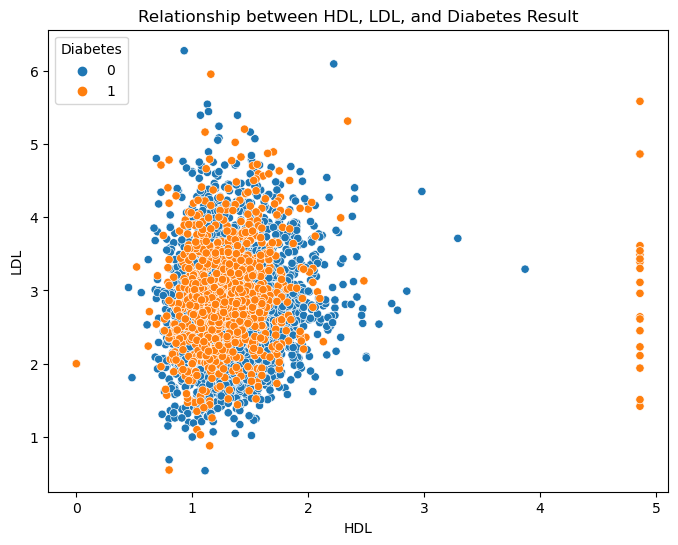

In [20]:
# Select variables related to diabetes
diabetes_variables = ['HDL', 'LDL', 'Diabetes']
diabetes_subset = df[diabetes_variables]

# Scatterplot for 'HDL' and 'LDL' in relation to diabetes
plt.figure(figsize=(8, 6))
sns.scatterplot(data=diabetes_subset, x='HDL', y='LDL', hue='Diabetes')
plt.title('Relationship between HDL, LDL, and Diabetes Result')
plt.xlabel('HDL')
plt.ylabel('LDL')
plt.savefig('fig2_hdl_ldl.png') 
plt.show()


In [21]:
classifiers = [
    {
        'name': 'GaussianNB',
        'estimator': GaussianNB(),
        'params': {}
    },
    {
        'name': 'RandomForest',
        'estimator': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20]
        },
        'selector': SelectKBest(score_func=f_classif, k=7)
    },
    {
        'name': 'XGBoost',
        'estimator': xgb.XGBClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7]
        },
        'selector': SelectKBest(score_func=f_classif, k=7)
    },
    {
        'name': 'LogisticRegression',
        'estimator': LogisticRegression(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'lbfgs', 'saga']
        }
    },
    {
        'name': 'DecisionTree',
        'estimator': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    {
        'name': 'KNeighbors',
        'estimator': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
        }
    },
    {
        'name': 'SVC',
        'estimator': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'gamma': ['scale', 'auto']
        }
    }
]

warnings.filterwarnings("ignore")

for clf_data in classifiers:
    clf = clf_data['estimator']
    clf_name = clf_data['name']
    params = clf_data['params']
    selector = clf_data.get('selector')  # Get the selector if it exists

    if selector is not None:
        # Perform feature selection with SelectKBest
        selector.fit(X_train_scaled, y_train)
        X_train_selected = selector.transform(X_train_scaled)
        X_cv_selected = selector.transform(X_cv_scaled)
    else:
        X_train_selected = X_train_scaled
        X_cv_selected = X_cv_scaled

    # Perform hyperparameter tuning on the classifier
    grid_search = GridSearchCV(clf, params, cv=5, scoring='f1')
    grid_search.fit(X_train_selected, y_train)
    
    # Perform cross-validation on the training set
    cv_scores = cross_val_score(grid_search.best_estimator_, X_train_selected, y_train, cv=5, scoring='f1')
    
    # Print the results for the current classifier
    print(f"Results for {clf_name}:")
    print(f"Best hyperparameters: {grid_search.best_params_}")
    print(f"Average cross-validation F1 score: {grid_search.best_score_}")
    print(f"Average training F1 score: {cv_scores.mean()}")
    print(f"Training F1 score standard deviation: {cv_scores.std()}")
    
    # Predict on the test set
    y_pred = grid_search.best_estimator_.predict(X_cv_selected)
    
    # Calculate evaluation metrics on the test set
    accuracy_test = accuracy_score(y_cv, y_pred)
    precision_test = precision_score(y_cv, y_pred)
    recall_test = recall_score(y_cv, y_pred)
    f1_test = f1_score(y_cv, y_pred)
    
    # Print evaluation metrics on the test set
    print(f"Results on the test set:")
    print(f"Accuracy: {accuracy_test}")
    print(f"Positive Precision (Precision): {precision_test}")
    print(f"Sensitivity (Recall): {recall_test}")
    print(f"F1 Score: {f1_test}")
    print("------------------------")
    

Results for GaussianNB:
Best hyperparameters: {}
Average cross-validation F1 score: 0.9234405855322482
Average training F1 score: 0.9234405855322482
Training F1 score standard deviation: 0.014987208563533753
Results on the test set:
Accuracy: 0.9442508710801394
Positive Precision (Precision): 0.9365079365079365
Sensitivity (Recall): 0.8805970149253731
F1 Score: 0.9076923076923077
------------------------
Results for RandomForest:
Best hyperparameters: {'max_depth': None, 'n_estimators': 200}
Average cross-validation F1 score: 0.926712470084612
Average training F1 score: 0.926712470084612
Training F1 score standard deviation: 0.010464711585594037
Results on the test set:
Accuracy: 0.9442508710801394
Positive Precision (Precision): 0.9365079365079365
Sensitivity (Recall): 0.8805970149253731
F1 Score: 0.9076923076923077
------------------------
Results for XGBoost:
Best hyperparameters: {'max_depth': 7, 'n_estimators': 50}
Average cross-validation F1 score: 0.9262473304028942
Average trai

In [22]:
param_grids = {
    'GaussianNB': {},  # No hyperparameters to tune
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10]
    },
    'DecisionTree': {  # Change to DecisionTree instead of DecisionTreeClassifier
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'KNeighbors': {  # Change to KNeighbors instead of KNeighborsClassifier
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    'RandomForest': {  # Change to RandomForest instead of RandomForestClassifier
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20]
    },
    'SVC': {
        'C': [0.01, 0.1, 1, 10]
    },
    'XGBoost': {  # Change to XGBoost instead of XGBClassifier
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7]
    }
}

# Iterate over classifiers and perform hyperparameter tuning
for clf_name in param_grids:
    clf_data = next((item for item in classifiers if item["name"] == clf_name), None)
    if clf_data is not None:
        print(f"Performing hyperparameter tuning for {clf_name}...")
        clf = clf_data['estimator']
        param_grid = param_grids[clf_name]
        grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
        grid_search.fit(X_train_selected, y_train)
        
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        
        print("Best hyperparameters:", best_params)
        print("Best F1 Score:", best_score)
        print("------------------------")

Performing hyperparameter tuning for GaussianNB...
Best hyperparameters: {}
Best F1 Score: 0.9234405855322482
------------------------
Performing hyperparameter tuning for LogisticRegression...
Best hyperparameters: {'C': 1}
Best F1 Score: 0.9154939050320134
------------------------
Performing hyperparameter tuning for DecisionTree...
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 5}
Best F1 Score: 0.917110877411049
------------------------
Performing hyperparameter tuning for KNeighbors...
Best hyperparameters: {'n_neighbors': 5, 'weights': 'uniform'}
Best F1 Score: 0.9213532969940539
------------------------
Performing hyperparameter tuning for RandomForest...
Best hyperparameters: {'max_depth': None, 'n_estimators': 200}
Best F1 Score: 0.926712470084612
------------------------
Performing hyperparameter tuning for SVC...
Best hyperparameters: {'C': 10}
Best F1 Score: 0.9215131223376538
------------------------
Performing hyperparameter tuning for XGBoost...
Best hyperp

Performing hyperparameter tuning for GaussianNB...
Best hyperparameters for accuracy: {}
Best accuracy Score: 0.9566108886989639
------------------------
Best hyperparameters for precision: {}
Best precision Score: 0.9616197518863704
------------------------
Best hyperparameters for recall: {}
Best recall Score: 0.8883384932920537
------------------------
Best hyperparameters for f1: {}
Best f1 Score: 0.9234405855322482
------------------------
Performing hyperparameter tuning for LogisticRegression...
Best hyperparameters for accuracy: {'C': 1}
Best accuracy Score: 0.9523503216229589
------------------------
Best hyperparameters for precision: {'C': 0.01}
Best precision Score: 0.9780534218310952
------------------------
Best hyperparameters for recall: {'C': 1}
Best recall Score: 0.8765221878224974
------------------------
Best hyperparameters for f1: {'C': 1}
Best f1 Score: 0.9154939050320134
------------------------
Performing hyperparameter tuning for DecisionTree...
Best hyperpara

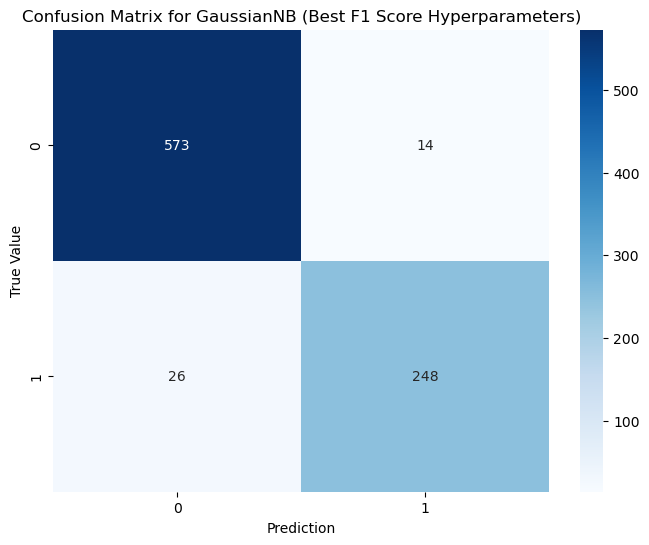

Plotting confusion matrix for LogisticRegression with best F1 Score hyperparameters...


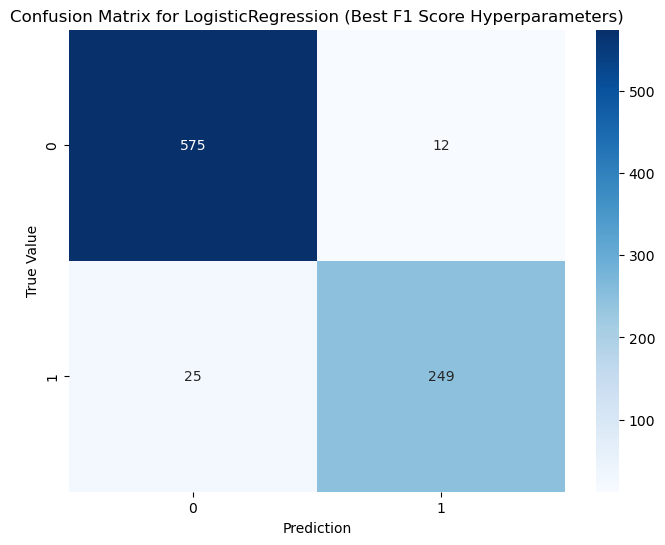

Plotting confusion matrix for DecisionTree with best F1 Score hyperparameters...


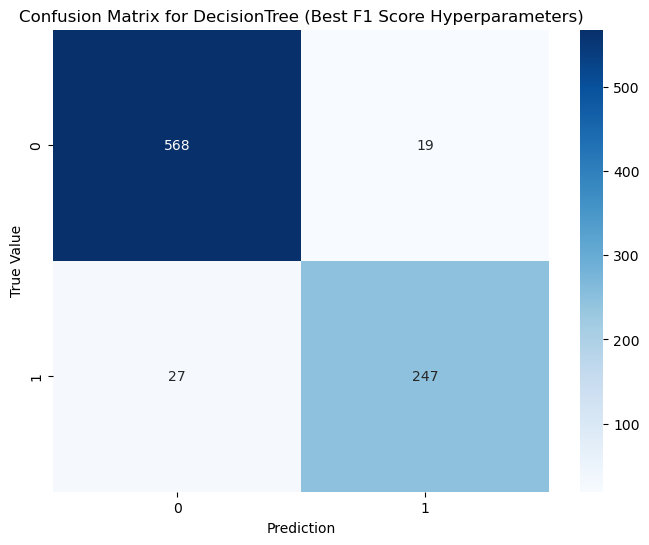

Plotting confusion matrix for KNeighbors with best F1 Score hyperparameters...


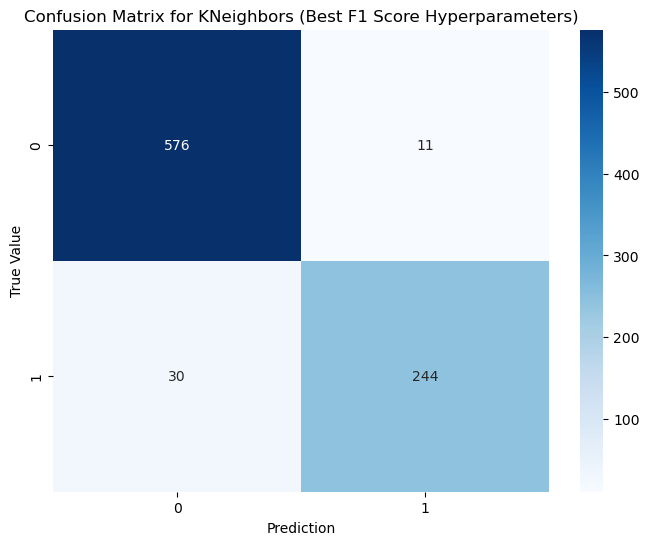

Plotting confusion matrix for RandomForest with best F1 Score hyperparameters...


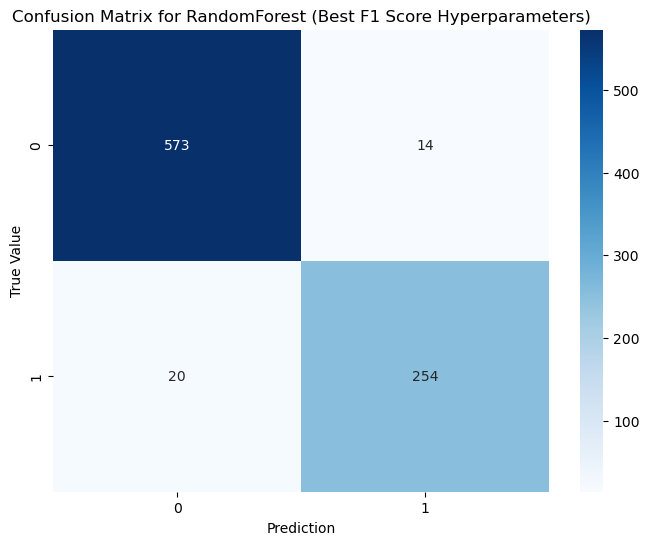

Plotting confusion matrix for SVC with best F1 Score hyperparameters...


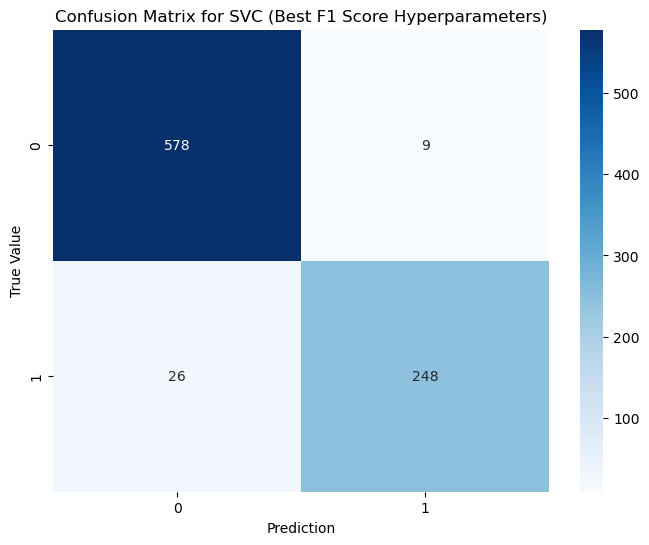

Plotting confusion matrix for XGBoost with best F1 Score hyperparameters...


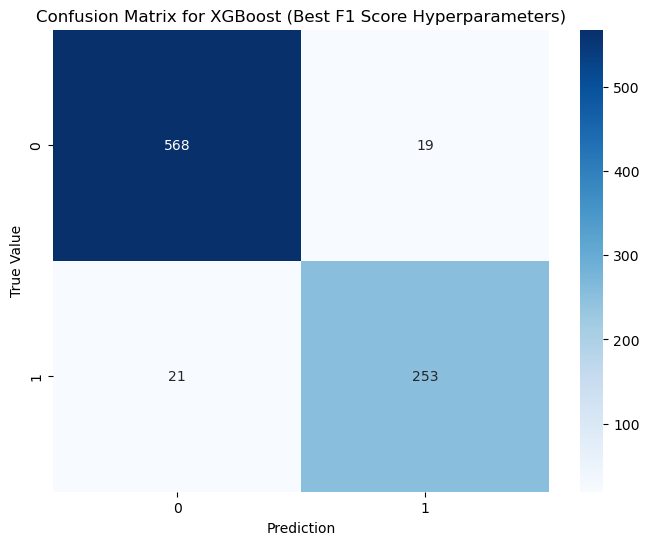

In [23]:
# Initialize dictionaries to store best hyperparameters and scores for each metric
best_params_accuracy = {}
best_params_precision = {}
best_params_recall = {}
best_params_f1 = {}

# Define the metrics you want to tune for
metrics_to_tune = ['accuracy', 'precision', 'recall', 'f1']

# Iterate over classifiers and perform hyperparameter tuning
for clf_name in param_grids:
    clf_data = next((item for item in classifiers if item["name"] == clf_name), None)
    if clf_data is not None:
        print(f"Performing hyperparameter tuning for {clf_name}...")
        clf = clf_data['estimator']
        param_grid = param_grids[clf_name]
        
        for metric in metrics_to_tune:
            grid_search = GridSearchCV(clf, param_grid, cv=5, scoring=metric)
            grid_search.fit(X_train_selected, y_train)
            
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
            
            print(f"Best hyperparameters for {metric}:", best_params)
            print(f"Best {metric} Score:", best_score)
            
            # Store the best hyperparameters and scores for each metric
            if metric == 'accuracy':
                best_params_accuracy[clf_name] = best_params
            elif metric == 'precision':
                best_params_precision[clf_name] = best_params
            elif metric == 'recall':
                best_params_recall[clf_name] = best_params
            elif metric == 'f1':
                best_params_f1[clf_name] = best_params
            
            print("------------------------")

# Iterate over classifiers and plot confusion matrices for the best F1 Score hyperparameters
for clf_name in param_grids:
    clf_data = next((item for item in classifiers if item["name"] == clf_name), None)
    if clf_data is not None:
        print(f"Plotting confusion matrix for {clf_name} with best F1 Score hyperparameters...")
        clf = clf_data['estimator']
        
        # Determine the best hyperparameters based on F1 Score
        best_hyperparameters = best_params_f1[clf_name]
        
        # Set the classifier with the best hyperparameters
        clf.set_params(**best_hyperparameters)
        
        # Train the classifier on the training set
        clf.fit(X_train_scaled, y_train)
        
        # Perform predictions on the test data using the classifier with the best hyperparameters
        y_pred = clf.predict(X_test_scaled)
        
        # Calculate the confusion matrix
        confusion_matrix_result = confusion_matrix(y_test, y_pred)
        
        # Create a heatmap for the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Prediction')
        plt.ylabel('True Value')
        plt.title(f'Confusion Matrix for {clf_name} (Best F1 Score Hyperparameters)')
        plt.savefig(f'confusion_matrix_{clf_name}.png')
        plt.show()

Performing hyperparameter tuning for GaussianNB based on recall...
Best hyperparameters for recall in GaussianNB: {}
Best Recall Score: 0.8883384932920537
------------------------
Performing hyperparameter tuning for LogisticRegression based on recall...
Best hyperparameters for recall in LogisticRegression: {'C': 1}
Best Recall Score: 0.8765221878224974
------------------------
Performing hyperparameter tuning for DecisionTree based on recall...
Best hyperparameters for recall in DecisionTree: {'max_depth': None, 'min_samples_split': 2}
Best Recall Score: 0.9067165462676299
------------------------
Performing hyperparameter tuning for KNeighbors based on recall...
Best hyperparameters for recall in KNeighbors: {'n_neighbors': 5, 'weights': 'distance'}
Best Recall Score: 0.8818025455796354
------------------------
Performing hyperparameter tuning for RandomForest based on recall...
Best hyperparameters for recall in RandomForest: {'max_depth': None, 'n_estimators': 100}
Best Recall Sco

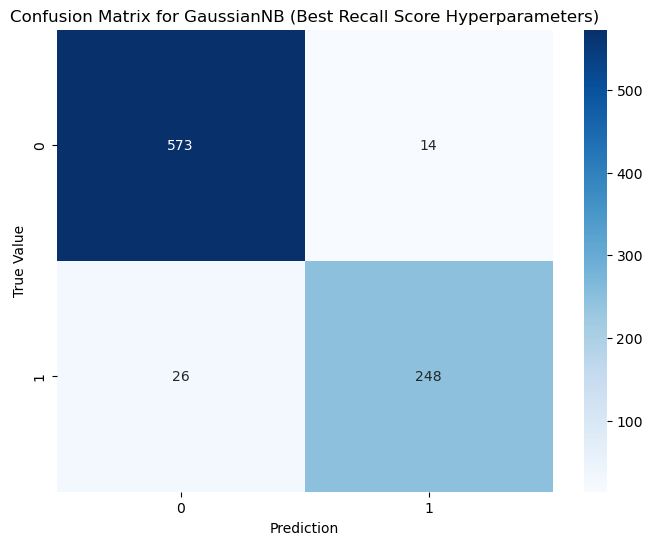

Plotting confusion matrix for LogisticRegression with best recall hyperparameters...


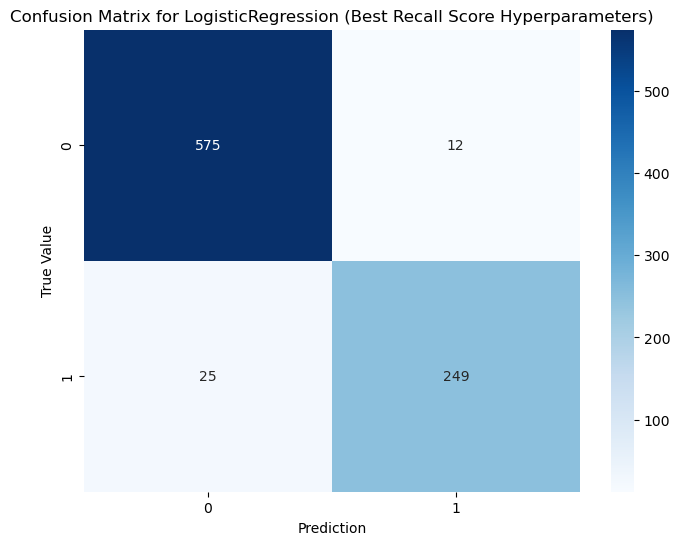

Plotting confusion matrix for DecisionTree with best recall hyperparameters...


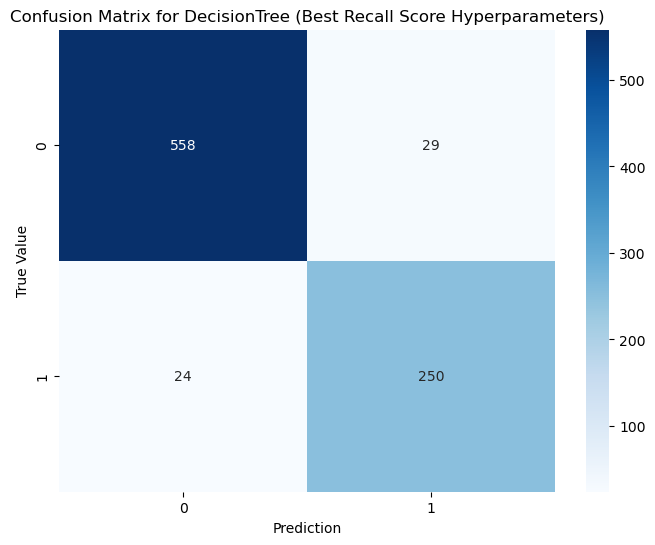

Plotting confusion matrix for KNeighbors with best recall hyperparameters...


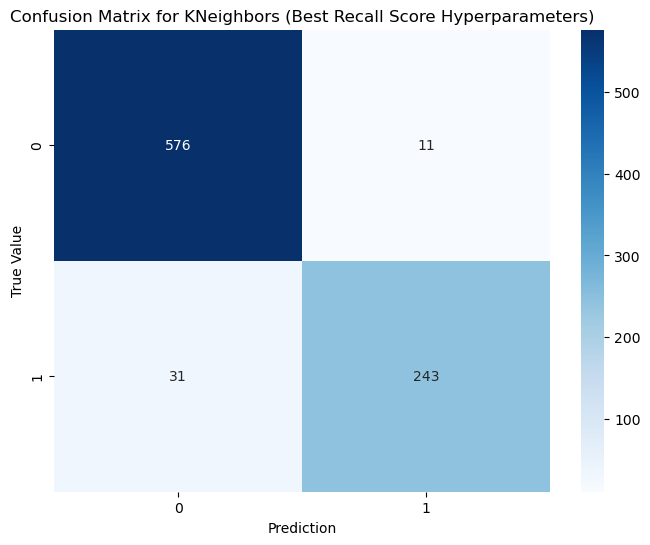

Plotting confusion matrix for RandomForest with best recall hyperparameters...


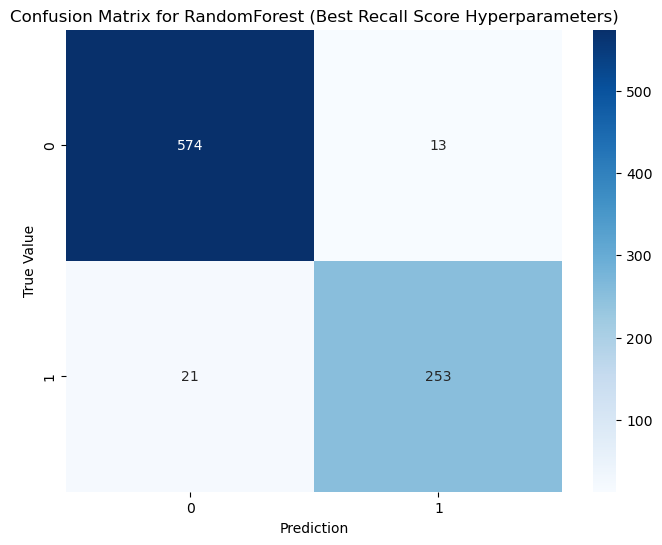

Plotting confusion matrix for SVC with best recall hyperparameters...


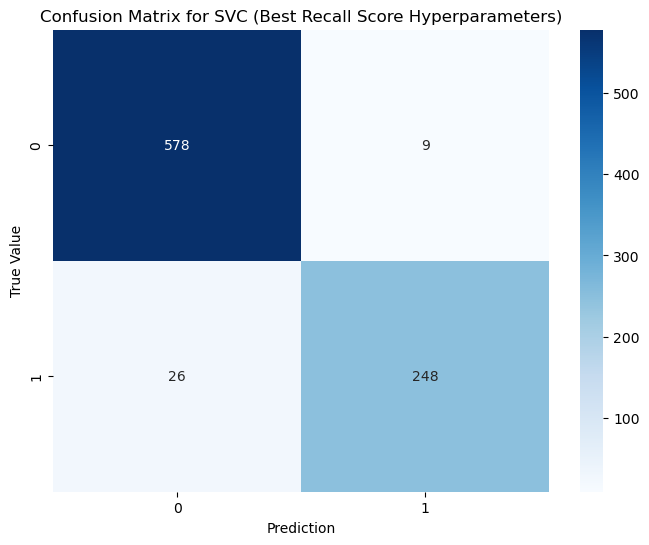

Plotting confusion matrix for XGBoost with best recall hyperparameters...


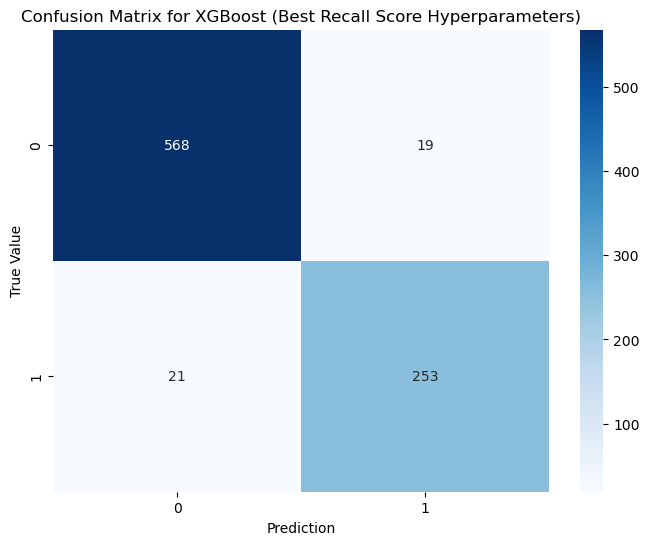

In [24]:
# Initialize a dictionary to store the best hyperparameters for recall
best_params_recall = {}

# Iterate over classifiers and perform hyperparameter tuning for recall
for clf_name in param_grids:
    clf_data = next((item for item in classifiers if item["name"] == clf_name), None)
    if clf_data is not None:
        print(f"Performing hyperparameter tuning for {clf_name} based on recall...")
        clf = clf_data['estimator']
        param_grid = param_grids[clf_name]
        
        grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='recall')
        grid_search.fit(X_train_scaled, y_train)
        
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        
        print(f"Best hyperparameters for recall in {clf_name}:", best_params)
        print(f"Best Recall Score:", best_score)
        
        # Store the best hyperparameters for recall
        best_params_recall[clf_name] = best_params
        print("------------------------")

# Iterate over classifiers and plot confusion matrices for the best recall hyperparameters
for clf_name, best_hyperparameters in best_params_recall.items():
    clf_data = next((item for item in classifiers if item["name"] == clf_name), None)
    if clf_data is not None:
        print(f"Plotting confusion matrix for {clf_name} with best recall hyperparameters...")
        clf = clf_data['estimator']
        
        # Set the classifier with the best hyperparameters for recall
        clf.set_params(**best_hyperparameters)
        
        # Train the classifier on the training set
        clf.fit(X_train_scaled, y_train)
        
        # Perform predictions on the test data using the classifier with the best hyperparameters
        y_pred = clf.predict(X_test_scaled)
        
        # Calculate the confusion matrix
        confusion_matrix_result = confusion_matrix(y_test, y_pred)
        
        # Create a heatmap for the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Prediction')
        plt.ylabel('True Value')
        plt.title(f'Confusion Matrix for {clf_name} (Best Recall Score Hyperparameters)')
        plt.show()

Metrics on test data:
Accuracy: 0.9581881533101045
Precision: 0.9541984732824428
Recall: 0.9124087591240876
F1 Score: 0.9328358208955224


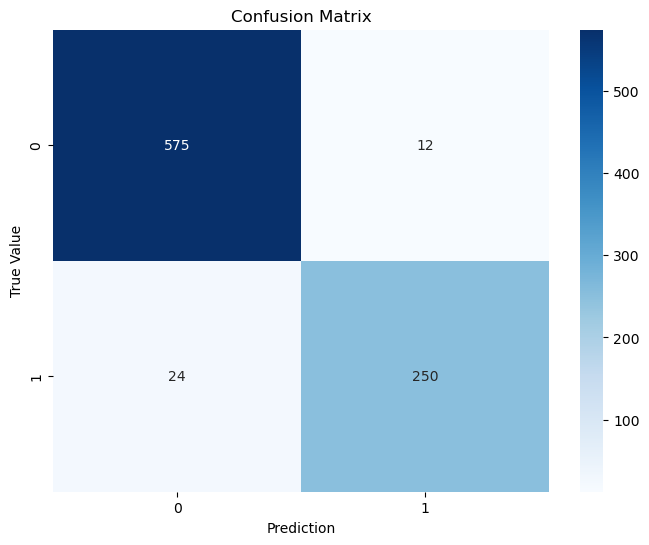

In [25]:

# Define individual classifiers with their hyperparameters
clf_naive_bayes = GaussianNB()
clf_logistic_regression = LogisticRegression(max_iter=1000, random_state=42)
clf_decision_tree = DecisionTreeClassifier(random_state=42)
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_random_forest = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=None)
clf_svc = SVC(probability=True, random_state=42)
clf_xgboost = xgb.XGBClassifier(random_state=42, n_estimators=50, max_depth=7)

# Create the VotingClassifier with Hard Voting
voting_clf_hard = VotingClassifier(
    estimators=[
        ('naive_bayes', clf_naive_bayes),
        ('logistic_regression', clf_logistic_regression),
        ('decision_tree', clf_decision_tree),
        ('knn', clf_knn),
        ('random_forest', clf_random_forest),
        ('svc', clf_svc),
        ('xgboost', clf_xgboost)
    ],
    voting='hard'  # Use Hard Voting
)

# Train the VotingClassifier with Hard Voting on the training set
voting_clf_hard.fit(X_train_scaled, y_train)

# Predict on the validation set using Hard Voting
y_pred_hard = voting_clf_hard.predict(X_cv_scaled)

# Calculate evaluation metrics on the validation set for Hard Voting
accuracy_hard = accuracy_score(y_cv, y_pred_hard)
precision_hard = precision_score(y_cv, y_pred_hard)
recall_hard = recall_score(y_cv, y_pred_hard)
f1_hard = f1_score(y_cv, y_pred_hard)

# Assuming you have your test data in X_test_scaled and labels in y_test

# Perform predictions on the test data using the Hard Voting ensemble
y_pred_hard_test = voting_clf_hard.predict(X_test_scaled)

# Calculate evaluation metrics on the test data
accuracy_test = accuracy_score(y_test, y_pred_hard_test)
precision_test = precision_score(y_test, y_pred_hard_test)
recall_test = recall_score(y_test, y_pred_hard_test)
f1_test = f1_score(y_test, y_pred_hard_test)

# Print the metrics on the test data
print("Metrics on test data:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)

# Perform predictions on the test data using the Hard Voting ensemble
y_pred_hard_test = voting_clf_hard.predict(X_test_scaled)

# Calculate the confusion matrix
confusion_matrix_result = confusion_matrix(y_test, y_pred_hard_test)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('True Value')
plt.title('Confusion Matrix')
plt.show()

Metrics on test data for Soft Voting:
Accuracy: 0.959349593495935
Precision: 0.9543726235741445
Recall: 0.916058394160584
F1 Score: 0.9348230912476724


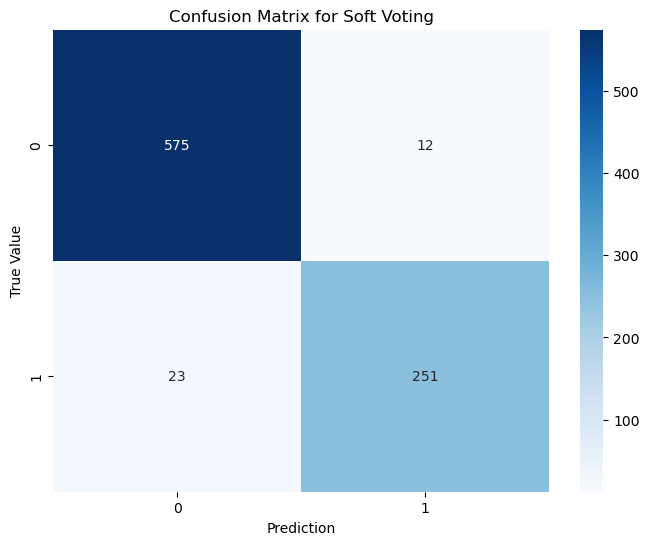

In [26]:
# Create the VotingClassifier with Soft Voting
voting_clf_soft = VotingClassifier(
    estimators=[
        ('naive_bayes', clf_naive_bayes),
        ('logistic_regression', clf_logistic_regression),
        ('decision_tree', clf_decision_tree),
        ('knn', clf_knn),
        ('random_forest', clf_random_forest),
        ('svc', clf_svc),
        ('xgboost', clf_xgboost)
    ],
    voting='soft'  # Use Soft Voting
)

# Train the VotingClassifier with Soft Voting on the training set
voting_clf_soft.fit(X_train_scaled, y_train)

# Predict on the validation set using Soft Voting
y_pred_soft = voting_clf_soft.predict(X_cv_scaled)

# Calculate evaluation metrics on the validation set for Soft Voting
accuracy_soft = accuracy_score(y_cv, y_pred_soft)
precision_soft = precision_score(y_cv, y_pred_soft)
recall_soft = recall_score(y_cv, y_pred_soft)
f1_soft = f1_score(y_cv, y_pred_soft)

# Assuming you have your test data in X_test_scaled and labels in y_test

# Perform predictions on the test data using the Soft Voting ensemble
y_pred_soft_test = voting_clf_soft.predict(X_test_scaled)

# Calculate evaluation metrics on the test data
accuracy_test_soft = accuracy_score(y_test, y_pred_soft_test)
precision_test_soft = precision_score(y_test, y_pred_soft_test)
recall_test_soft = recall_score(y_test, y_pred_soft_test)
f1_test_soft = f1_score(y_test, y_pred_soft_test)

# Print the metrics on the test data for Soft Voting
print("Metrics on test data for Soft Voting:")
print("Accuracy:", accuracy_test_soft)
print("Precision:", precision_test_soft)
print("Recall:", recall_test_soft)
print("F1 Score:", f1_test_soft)

# Calculate the confusion matrix for Soft Voting
confusion_matrix_result_soft = confusion_matrix(y_test, y_pred_soft_test)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result_soft, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('True Value')
plt.title('Confusion Matrix for Soft Voting')
plt.show()

In [27]:

# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # For binary classification
])

# Define custom metric functions
def custom_precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def custom_recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def custom_f1_score(y_true, y_pred):
    p = custom_precision(y_true, y_pred)
    r = custom_recall(y_true, y_pred)
    f1 = 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))
    return f1

# Compile the model with custom metrics
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', custom_precision, custom_recall, custom_f1_score])

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
results = model.evaluate(X_test_scaled, y_test)
loss = results[0]
accuracy = results[1]
precision = results[2]
recall = results[3]
f1_score_value = results[4]

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')
print(f'Test precision: {precision:.4f}')
print(f'Test recall: {recall:.4f}')
print(f'Test F1-score: {f1_score_value:.4f}')

Epoch 1/10
65/65 [==============================] - 3s 16ms/step - loss: 0.4603 - accuracy: 0.7960 - custom_precision: 0.6989 - custom_recall: 0.5988 - custom_f1_score: 0.5940 - val_loss: 0.3593 - val_accuracy: 0.8530 - val_custom_precision: 0.8660 - val_custom_recall: 0.7155 - val_custom_f1_score: 0.7712
Epoch 2/10
65/65 [==============================] - 0s 5ms/step - loss: 0.2572 - accuracy: 0.9016 - custom_precision: 0.8310 - custom_recall: 0.8035 - custom_f1_score: 0.8055 - val_loss: 0.2532 - val_accuracy: 0.8859 - val_custom_precision: 0.8367 - val_custom_recall: 0.8355 - val_custom_f1_score: 0.8292
Epoch 3/10
65/65 [==============================] - 0s 5ms/step - loss: 0.2080 - accuracy: 0.9220 - custom_precision: 0.8632 - custom_recall: 0.8523 - custom_f1_score: 0.8525 - val_loss: 0.2257 - val_accuracy: 0.9091 - val_custom_precision: 0.9110 - val_custom_recall: 0.8209 - val_custom_f1_score: 0.8539
Epoch 4/10
65/65 [==============================] - 0s 5ms/step - loss: 0.1864 - 

In [28]:
predictions = model.predict(X_test_scaled)

# Create a dataframe to save results
results_df = pd.DataFrame({
    'True Labels': y_test,
    'Predicted Probabilities': predictions.reshape(-1)
})

# Save results on CSV file
results_df.to_csv('results_cnn.csv', index=False)

27/27 [==============================] - 0s 2ms/step


In [29]:
from sklearn.metrics import f1_score as f1_score_func
# Assuming you already have your trained model and test data X_test_scaled
predicted_labels = model.predict(X_test_scaled)
predicted_probabilities = predicted_labels.squeeze()  # Ensure probabilities are in a one-dimensional array
true_labels = y_test  # Ensure y_test contains the true labels

# Then, you can use predicted_probabilities and true_labels in your code
best_metrics = {
    'threshold': None,
    'accuracy': 0,
    'precision': 0,
    'recall': 0,
    'f1_score_v': 0  # Rename this variable to avoid conflicts
}

for threshold in np.arange(0, 1.01, 0.01):
    predicted_binary_labels = (predicted_probabilities > threshold).astype(int)
    
    accuracy = accuracy_score(true_labels, predicted_binary_labels)
    precision = precision_score(true_labels, predicted_binary_labels)
    recall = recall_score(true_labels, predicted_binary_labels)
    f1 = f1_score_func(true_labels, predicted_binary_labels)  # Use the imported function
    
    if f1 > best_metrics['f1_score_v']:
        best_metrics = {
            'threshold': threshold,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score_v': f1  # Rename here as well
        }

print(f'Best metrics at threshold {best_metrics["threshold"]:.2f}:')
print(f'Accuracy: {best_metrics["accuracy"]:.4f}')
print(f'Precision: {best_metrics["precision"]:.4f}')
print(f'Recall: {best_metrics["recall"]:.4f}')
print(f'F1-Score: {best_metrics["f1_score_v"]:.4f}')

27/27 [==============================] - 0s 2ms/step
Best metrics at threshold 0.42:
Accuracy: 0.9524
Precision: 0.9206
Recall: 0.9307
F1-Score: 0.9256


In [30]:

# Load the file with predicted results from the model
results_df = pd.read_csv('results_cnn.csv')

# Get true labels and predicted probabilities
true_labels = results_df['True Labels']
predicted_probabilities = results_df['Predicted Probabilities']

# Define a threshold (adjust as needed)
threshold = 0.40

# Convert probabilities into predicted labels
predicted_labels = (predicted_probabilities > threshold).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1_score_value = f1_score_func(true_labels, predicted_labels)

roc_auc = roc_auc_score(true_labels, predicted_probabilities)

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1_score_value:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')


Accuracy: 0.9512
Precision: 0.9143
Recall: 0.9343
F1-Score: 0.9242
ROC AUC: 0.9851


In [31]:
# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Create a classification report
class_report = classification_report(true_labels, predicted_labels, target_names=['Negative Class', 'Positive Class'])

print('Confusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(class_report)

Confusion Matrix:
[[563  24]
 [ 18 256]]

Classification Report:
                precision    recall  f1-score   support

Negative Class       0.97      0.96      0.96       587
Positive Class       0.91      0.93      0.92       274

      accuracy                           0.95       861
     macro avg       0.94      0.95      0.94       861
  weighted avg       0.95      0.95      0.95       861



In [32]:
comparison_df = pd.DataFrame({
    'Original Value': true_labels,
    'Predicted Label': predicted_labels
})

# Add a column to indicate if the prediction was correct or not
comparison_df['Correct Prediction'] = np.where(comparison_df['Original Value'] == comparison_df['Predicted Label'], 'Yes', 'No')

# Print the comparison table
print(comparison_df)


     Original Value  Predicted Label Correct Prediction
0                 1                1                Yes
1                 1                1                Yes
2                 0                0                Yes
3                 1                1                Yes
4                 0                0                Yes
..              ...              ...                ...
856               1                1                Yes
857               0                0                Yes
858               1                1                Yes
859               1                1                Yes
860               0                0                Yes

[861 rows x 3 columns]


In [33]:
comparison_df.to_csv('comparison_results.csv', index=False)

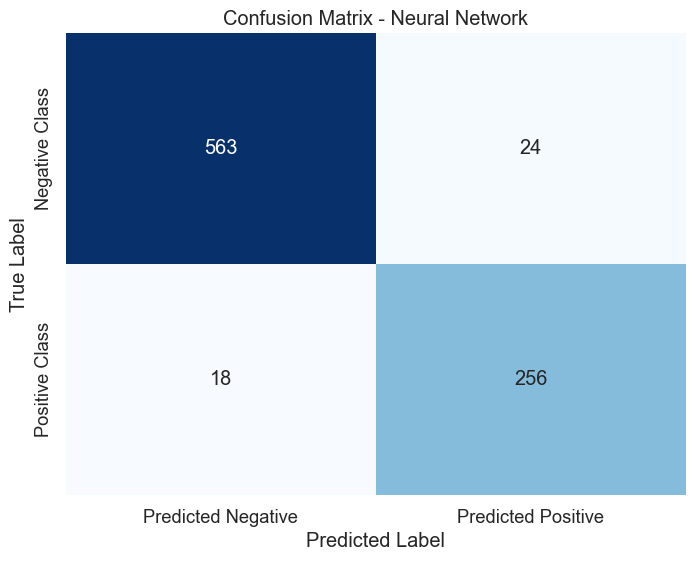

In [34]:
# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Create a DataFrame from the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Negative Class', 'Positive Class'], columns=['Predicted Negative', 'Predicted Positive'])

# Create the heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Neural Network')
plt.show()

In [35]:

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train_scaled.shape[1],)))

    # Add hidden layers with different options for the number of units
    for i in range(hp.Int('num_hidden_layers', min_value=1, max_value=3)):
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32), activation='relu'))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize the four tuners
random_tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='random_search_dir',
    project_name='random_search_project'
)

hyperband_tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hyperband_dir',
    project_name='hyperband_project'
)

bayesian_tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    directory='bayesian_search_dir',
    project_name='bayesian_search_project'
)

# Perform hyperparameter search for each tuner
random_tuner.search(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)
hyperband_tuner.search(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)
bayesian_tuner.search(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Get the best model from each tuner
best_random_model = random_tuner.get_best_models(num_models=1)[0]
best_hyperband_model = hyperband_tuner.get_best_models(num_models=1)[0]
best_bayesian_model = bayesian_tuner.get_best_models(num_models=1)[0]

# Evaluate the best models on the test set
random_loss, random_accuracy = best_random_model.evaluate(X_test_scaled, y_test)
hyperband_loss, hyperband_accuracy = best_hyperband_model.evaluate(X_test_scaled, y_test)
bayesian_loss, bayesian_accuracy = best_bayesian_model.evaluate(X_test_scaled, y_test)

print(f'Test accuracy with RandomSearch: {random_accuracy:.4f}')
print(f'Test accuracy with Hyperband: {hyperband_accuracy:.4f}')
print(f'Test accuracy with BayesianOptimization: {bayesian_accuracy:.4f}')

Trial 10 Complete [00h 00m 12s]
val_accuracy: 0.9323017597198486

Best val_accuracy So Far: 0.9555125832557678
Total elapsed time: 00h 01m 43s
INFO:tensorflow:Oracle triggered exit
27/27 [==============================] - 1s 4ms/step - loss: 0.1292 - accuracy: 0.9524
Test accuracy with RandomSearch: 0.9582
Test accuracy with Hyperband: 0.9593
Test accuracy with BayesianOptimization: 0.9524


In [36]:

# Define an objective function for optimization
def objective(params):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)))

    for _ in range(params['num_hidden_layers']):
        model.add(tf.keras.layers.Dense(units=params['units'], activation='relu'))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
                  loss='binary_crossentropy', 
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall()])

    model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    y_pred = model.predict(X_cv_scaled)
    y_pred_rounded = np.round(y_pred)
    
    precision = precision_score(y_cv, y_pred_rounded)
    recall = recall_score(y_cv, y_pred_rounded)
    f1 = f1_score(y_cv, y_pred_rounded)
    
    return -f1  # Minimize the negative of F1-score

# Define the search space
space = {
    'num_hidden_layers': hp.choice('num_hidden_layers', [1, 2, 3]),
    'units': hp.choice('units', [32, 64, 128, 256]),
    'learning_rate': hp.loguniform('learning_rate', -5, -1)
}

# Perform the search using TPE (Tree-structured Parzen Estimator)
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

print("Best hyperparameters:", best)

27/27 [==============================] - 0s 3ms/step 

27/27 [==============================] - 0s 2ms/step                            

27/27 [==============================] - 0s 3ms/step                            

27/27 [==============================] - 0s 2ms/step                            

27/27 [==============================] - 0s 3ms/step                            

27/27 [==============================] - 0s 3ms/step                            

27/27 [==============================] - 0s 3ms/step                            

27/27 [==============================] - 0s 3ms/step                            

27/27 [==============================] - 0s 5ms/step                            

27/27 [==============================] - 0s 2ms/step                            

100%|██████████| 10/10 [00:57<00:00,  5.77s/trial, best loss: -0.9176470588235294]
Best hyperparameters: {'learning_rate': 0.024917053267953678, 'num_hidden_layers': 1, 'units': 2}


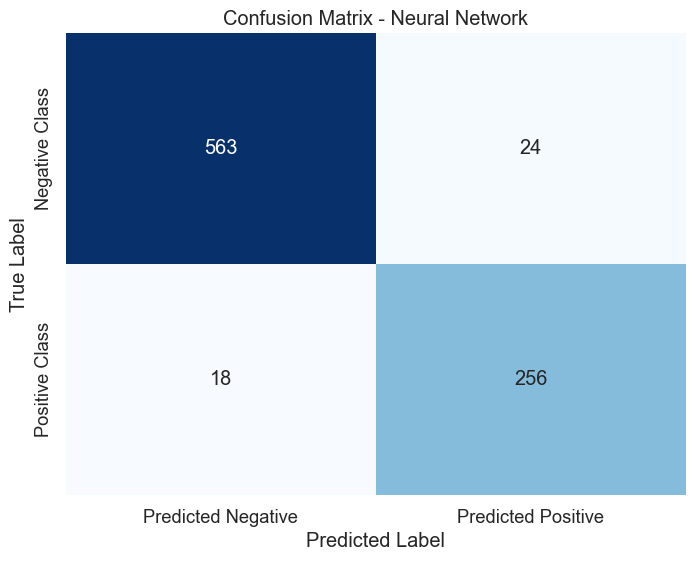

In [37]:
# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Create a DataFrame from the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Negative Class', 'Positive Class'], columns=['Predicted Negative', 'Predicted Positive'])
# Create the heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Neural Network')
plt.show()

In [38]:
# Define an objective function for optimization
def objective(params):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)))

    for _ in range(params['num_hidden_layers']):
        model.add(tf.keras.layers.Dense(units=params['units'], activation='relu'))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    y_pred = model.predict(X_cv_scaled)
    y_pred_rounded = np.round(y_pred)
    
    precision = precision_score(y_cv, y_pred_rounded)
    recall = recall_score(y_cv, y_pred_rounded)
    f1 = f1_score(y_cv, y_pred_rounded)
    
    return -f1  # Minimize the negative of F1-score

# Define the search space
space = {
    'num_hidden_layers': hp.choice('num_hidden_layers', [1, 2, 3]),
    'units': hp.choice('units', [32, 64, 128, 256]),
    'learning_rate': hp.loguniform('learning_rate', -5, -1)
}

# Perform the search using TPE (Tree-structured Parzen Estimator)
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

print("Best hyperparameters:", best)

27/27 [==============================] - 0s 2ms/step 

27/27 [==============================] - 0s 3ms/step                            

27/27 [==============================] - 0s 2ms/step                            

27/27 [==============================] - 0s 2ms/step                            

27/27 [==============================] - 0s 2ms/step                            

27/27 [==============================] - 0s 3ms/step                            

27/27 [==============================] - 0s 3ms/step                            

27/27 [==============================] - 0s 3ms/step                            

27/27 [==============================] - 0s 2ms/step                            

27/27 [==============================] - 0s 2ms/step                            

100%|██████████| 10/10 [00:45<00:00,  4.53s/trial, best loss: -0.9233716475095785]
Best hyperparameters: {'learning_rate': 0.007145250865339683, 'num_hidden_layers': 1, 'units': 0}


In [39]:

# Define the model with the best hyperparameters
best_model = tf.keras.Sequential()
best_model.add(tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)))

# Hidden layer
best_model.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Output layer
best_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model with the optimal learning rate
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02185562087710358),
                   loss='binary_crossentropy',
                   metrics=[tf.keras.metrics.Recall()])

# Train the model
best_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = best_model.evaluate(X_test_scaled, y_test)
print(f'Test accuracy: {accuracy:.4f}')

Epoch 1/10
65/65 [==============================] - 2s 10ms/step - loss: 0.2527 - recall_10: 0.8191 - val_loss: 0.1846 - val_recall_10: 0.8817
Epoch 2/10
65/65 [==============================] - 0s 4ms/step - loss: 0.1560 - recall_10: 0.8661 - val_loss: 0.1656 - val_recall_10: 0.8656
Epoch 3/10
65/65 [==============================] - 0s 4ms/step - loss: 0.1383 - recall_10: 0.8800 - val_loss: 0.1834 - val_recall_10: 0.9194
Epoch 4/10
65/65 [==============================] - 0s 4ms/step - loss: 0.1354 - recall_10: 0.8817 - val_loss: 0.1493 - val_recall_10: 0.8925
Epoch 5/10
65/65 [==============================] - 0s 4ms/step - loss: 0.1215 - recall_10: 0.8904 - val_loss: 0.1539 - val_recall_10: 0.8978
Epoch 6/10
65/65 [==============================] - 0s 5ms/step - loss: 0.1118 - recall_10: 0.8904 - val_loss: 0.1496 - val_recall_10: 0.9086
Epoch 7/10
65/65 [==============================] - 0s 4ms/step - loss: 0.1184 - recall_10: 0.8957 - val_loss: 0.1470 - val_recall_10: 0.9086
Epoch

27/27 [==============================] - 0s 2ms/step


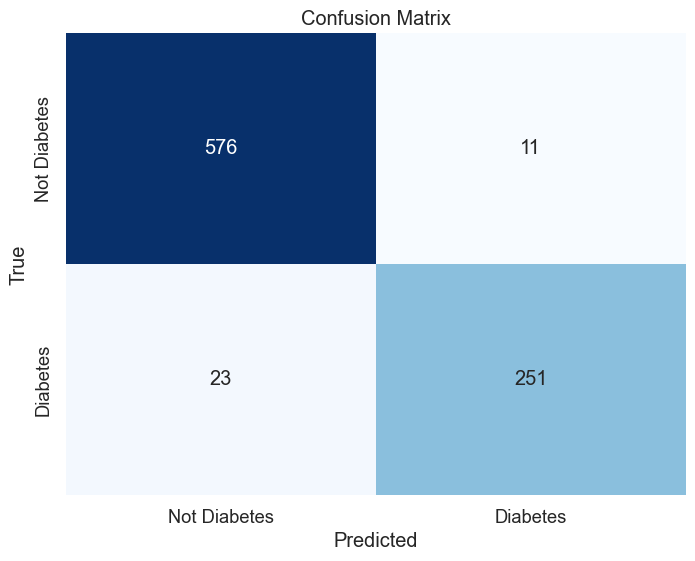

In [40]:
# Evaluate the model on the test set using recall
y_pred = best_model.predict(X_test_scaled)
y_pred = (y_pred > 0.5).astype(int)  # Convert predicted probabilities to binary predictions

# Compute the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Not Diabetes', 'Diabetes'],
            yticklabels=['Not Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('fig5_confmatrx.png') 
plt.show()
